In [1]:
import numpy as np
from datascience import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# 1. Preprocessing

## 1.1 Converting File Format


In [ ]:
pip install pdfplumber

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 8.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 9.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pdfplumber
import warnings
import logging

# To ignore the warnings
warnings.filterwarnings("ignore")
logging.getLogger("pdfminer").setLevel(logging.ERROR)

with pdfplumber.open('killed-in-gaza_moh_2025-03-23.pdf') as pdf:
    total_pages = len(pdf.pages)
    batch_size = 50  # process 50 pages at a time
    batch_number = 1

    for start_page in range(0, total_pages, batch_size):
        end_page = min(start_page + batch_size, total_pages)
        print(f"Processing pages {start_page+1} to {end_page}...")

        batch_rows = []
        columns = None

        for page_num in range(start_page, end_page):
            page = pdf.pages[page_num]
            table = page.extract_table()
            if table:
                if columns is None:
                    columns = table[0]  # first page -> header
                    batch_rows.extend(table[1:])  # first page -> skip header
                else:
                    batch_rows.extend(table)  # other pages -> take all rows

        if batch_rows:
            # Building a small Table for this batch
            batch_table = Table().with_columns(*[(col, []) for col in columns])

            for row in batch_rows:
                batch_table = batch_table.with_row(row)

            # Saving this batch separately
            filename = f'killed_in_gaza_batch_{batch_number}.csv'
            batch_table.to_csv(filename)

        batch_number += 1

Processing pages 1 to 50...
Processing pages 51 to 100...
Processing pages 101 to 150...
Processing pages 151 to 200...
Processing pages 201 to 250...
Processing pages 251 to 300...
Processing pages 301 to 350...
Processing pages 351 to 400...
Processing pages 401 to 450...
Processing pages 451 to 500...
Processing pages 501 to 550...
Processing pages 551 to 600...
Processing pages 601 to 650...
Processing pages 651 to 700...
Processing pages 701 to 750...
Processing pages 751 to 800...
Processing pages 801 to 850...
Processing pages 851 to 900...
Processing pages 901 to 950...
Processing pages 951 to 981...


In [83]:
import csv
import glob
import os

# Finding all CSV files
csv_files = sorted(glob.glob('killed_in_gaza_batch_*.csv'))

# Creating a file to store the combined output
with open('killed_in_gaza.csv', 'w', encoding='utf-8-sig', newline='') as output_file:
    writer = None

    for filename in csv_files:
        with open(filename, 'r', encoding='utf-8-sig') as f:
            reader = csv.reader(f)

            if writer is None:
                headers = next(reader)  # read header
                writer = csv.writer(output_file)
                writer.writerow(headers)

            for row in reader:
                writer.writerow(row)
        os.remove(filename)


In [84]:
import json

# Loading JSON
with open('infrastructure-damaged_2025-04-12.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Flattening records
flattened_data = []

for record in data:
    flat_record = {}
    for key, value in record.items():
        if isinstance(value, dict):
            for sub_key, sub_value in value.items():
                flat_record[f"{key}_{sub_key}"] = sub_value
        else:
            flat_record[key] = value
    flattened_data.append(flat_record)

# Finding all possible headers from all records
all_keys = set()
for row in flattened_data:
    all_keys.update(row.keys())

# headers = sorted(all_keys)

# Saving to CSV
with open('infrastructure_damaged.csv', 'w', newline='', encoding='utf-8-sig') as f:
    writer = csv.DictWriter(f, fieldnames=headers)
    writer.writeheader()

    for row in flattened_data:
        # filling missing keys with 0
        complete_row = {key: row.get(key, 0) for key in headers}
        writer.writerow(complete_row)


## 1.2 Datasets

In [85]:
daily_casualties_gaza = Table.read_table('casualties_daily_gaza_2025-04-12.csv')
daily_casualties_gaza.show(10)

report_date,report_source,report_period,ext_massacres_cum,killed,killed_cum,ext_killed,ext_killed_cum,ext_killed_children_cum,ext_killed_women_cum,injured_cum,ext_injured,ext_injured_cum,ext_civdef_killed_cum,med_killed_cum,ext_med_killed_cum,press_killed_cum,ext_press_killed_cum
2023-10-07,mohtel,24,0,232,232,232,232,0,0,1610,1610,1610,0,6,6,1,1
2023-10-08,mohtel,24,0,138,370,138,370,78,41,1788,178,1788,0,nan,6,1,1
2023-10-09,mohtel,24,8,190,560,190,560,91,61,2271,483,2271,0,6,6,3,3
2023-10-10,mohtel,24,8,340,900,340,900,260,230,4000,1729,4000,0,nan,6,7,7
2023-10-11,gmotel,24,23,200,1100,200,1100,398,230,5184,1184,5184,0,10,10,nan,7
2023-10-12,mohtel,24,23,317,1417,317,1417,500,276,5763,579,5763,0,11,11,nan,7
2023-10-13,missing,24,23,483,1900,483,1900,500,392,nan,1475,7238,0,11,11,nan,7
2023-10-14,gmotel,24,23,328,2228,328,2228,600,600,8714,1476,8714,0,11,11,nan,7
2023-10-15,gmotel,24,23,442,2670,442,2670,700,735,9200,486,9200,0,nan,11,nan,7
2023-10-16,gmotel,24,371,138,2808,138,2808,853,936,10850,1650,10850,7,37,37,nan,7


In [86]:
daily_casualties_westbank = Table.read_table('casualties_daily_west_bank_2025-04-12.csv')
daily_casualties_westbank.show(5)

report_date,verified.killed,verified.killed_cum,verified.injured,verified.injured_cum,verified.killed_children,verified.killed_children_cum,verified.injured_children,verified.injured_children_cum,killed_cum,killed_children_cum,injured_cum,injured_children_cum,settler_attacks_cum,flash_source
2023-10-07,6,6,197,197,2,2,31,31,3,0,23,1,3,un
2023-10-08,8,14,127,324,3,5,7,38,13,1,194,1,9,un
2023-10-09,4,18,88,412,0,5,19,57,15,3,295,34,19,un
2023-10-10,5,23,72,484,0,5,7,64,19,3,332,39,29,un
2023-10-11,6,29,85,569,2,7,17,81,26,3,427,62,39,un


In [2]:
killed_in_gaza = Table.read_table('killed_in_gaza.csv')
# killed_in_gaza.sort("Index", descending=True).show(5)
killed_in_gaza.show(5)

Index,Name,مس#ا,Born,Age,Sex,ID number
1,Mohammed Hani Mohammed Al-Zahhar,راهزلا دمحم يناه دمحم,2023-08-09,0,m,444196471
2,Nour Mohammed Aed Udwan,ناودع دئاع دمحم رون,2023-02-27,0,f,444484729
3,Khaled Mumin Amin Shabir,ريبش 6ما نمؤم دلاخ,2023-04-16,0,m,444799647
4,Yamen Ibrahim Farid Qaddoura,هرودق ديرف ميهاربا نماي,2023-06-10,0,m,445958408
5,Ahmed Rami Ahmed Abdel Qadir,رداقلا دبع دمحأ يمار دمحأ,2022-12-22,0,m,445808546


In [87]:
infrastructure_damaged = Table.read_table('infrastructure_damaged.csv')

# Making report_date the first column
labels = list(infrastructure_damaged.labels)
labels.remove('report_date')
new_order = ['report_date'] + labels  # Put it first

# Rearrange the Table
infrastructure_damaged = infrastructure_damaged.select(new_order)

infrastructure_damaged.show(5)

report_date,civic_buildings_destroyed,civic_buildings_ext_destroyed,educational_buildings_damaged,educational_buildings_destroyed,educational_buildings_ext_damaged,educational_buildings_ext_destroyed,places_of_worship_churches_destroyed,places_of_worship_ext_churches_destroyed,places_of_worship_ext_mosques_damaged,places_of_worship_ext_mosques_destroyed,places_of_worship_mosques_damaged,places_of_worship_mosques_destroyed,residential_destroyed,residential_ext_destroyed
2023-10-07,0,5,0,0,15,1,0,0,4,2,0,0,0,80
2023-10-08,0,11,0,0,30,1,0,0,8,4,0,0,159,159
2023-10-09,0,16,0,0,45,2,0,0,12,6,0,0,790,790
2023-10-10,0,22,0,0,60,2,0,0,17,8,0,0,1009,1009
2023-10-11,27,27,75,3,75,3,0,0,21,10,0,10,2835,2835


## 1.3 Data Quality Assessment

Before analyzing our datasets, we need to understand their quality and identify any issues that might affect our analysis.
We'll examine all columns in each dataset to identify missing values and understand patterns in the data.

Because of the challenging conditions under which this data is collected, we expect to see some gaps. By understanding these gaps, we can make appropriate cleaning decisions that preserve the integrity of the data.

In [7]:
def check_dataset_quality(table, dataset_name):
    """
    Checks the quality of an entire datascience.Table dataset.
    table: A datascience.Table object
    dataset_name: String with the name of the dataset for reporting
    """
    print(f"\n---------- CHECKING QUALITY OF {dataset_name} ----------")
    #create a results table
    results = Table().with_columns('column Name', [],'data type', [],'count', [],'num missing', [],'percent missing', [],'num unique values', [],
        'min value', [],'max value', [])
    num_rows = table.num_rows
    print(f"Total rows: {num_rows}")
    for col_name in table.labels:
        print(f"\nchecking column: {col_name}")
        #extract column as an array
        col_values = table.column(col_name)
        try:
            example_value = col_values.item(0) if num_rows > 0 else None
            data_type = type(example_value).__name__
        except:
            data_type = "unknown"
        #count missing/none values
        none_count = 0
        try:
            none_count = table.where(col_name, are.equal_to(None)).num_rows
        except:
            pass
        #np.nan
        nan_count = 0
        try:
            #for the numeric columns, check if values are NaN
            if data_type in ('int', 'float'):
                def is_nan(x):
                    try:
                        return np.isnan(x)
                    except:
                        return False
                nan_array = table.apply(is_nan, col_name)
                nan_count = sum(nan_array)
        except:
            pass
        #count empty strings for text columns
        empty_count = 0
        try:
            if data_type == 'str':
                empty_count = table.where(col_name, are.equal_to('')).num_rows
        except:
            pass
        #total missing
        total_missing = none_count + nan_count + empty_count
        percent_missing = (total_missing / num_rows * 100) if num_rows > 0 else 0

        #unique values
        unique_count = 0
        try:
            #group by the column and count unique values
            unique_count = table.group(col_name).num_rows
        except:
            pass
        #get min and max just to see if any unuslally small or large vals
        min_value = "N/A"
        max_value = "N/A"
        try:
            if data_type in ('int', 'float'):
                valid_values = table.where(col_name, are.not_equal_to(None)).column(col_name)
                if len(valid_values) > 0:
                    min_value = min(valid_values)
                    max_value = max(valid_values)
        except:
            pass
        results = results.with_row([
            col_name,
            data_type,
            num_rows,
            total_missing,
            round(percent_missing, 2),
            unique_count,
            min_value,
            max_value
        ])

    #print a summary
    problem_cols = results.where('percent missing', are.above(0))
    if problem_cols.num_rows > 0:
        print("\n----- SUMMARY OF DATA QUALITY ISSUES -----")
        print(f"Found {problem_cols.num_rows} columns with missing values:")
        problem_cols.select('column Name', 'percent missing').show()
    else:
        print("\nNo missing values found in any columns!")
    return results

In [8]:
def check_all_datasets_quality():

    gaza_results = check_dataset_quality(daily_casualties_gaza, "GAZA CASUALTIES")
    westbank_results = check_dataset_quality(daily_casualties_westbank, "WEST BANK CASUALTIES")
    infra_results = check_dataset_quality(infrastructure_damaged, "INFRASTRUCTURE DAMAGE")
    killed_results = check_dataset_quality(killed_in_gaza, "KILLED IN GAZA")

    all_datasets = Table().with_columns(
        'Dataset', ['Gaza Casualties', 'West Bank Casualties', 'Infrastructure Damage', 'Killed in Gaza'],
        'Rows', [
            daily_casualties_gaza.num_rows,
            daily_casualties_westbank.num_rows,
            infrastructure_damaged.num_rows,
            killed_in_gaza.num_rows
        ],
        'Columns', [
            len(daily_casualties_gaza.labels),
            len(daily_casualties_westbank.labels),
            len(infrastructure_damaged.labels),
            len(killed_in_gaza.labels)
        ]
    )

    print("\n---------- OVERALL DATASET SUMMARY ----------")
    all_datasets.show()

    return gaza_results, westbank_results, infra_results, killed_results

gaza_results, westbank_results, infra_results, killed_results = check_all_datasets_quality()


---------- CHECKING QUALITY OF GAZA CASUALTIES ----------
Total rows: 551

checking column: report_date

checking column: report_source

checking column: report_period

checking column: ext_massacres_cum

checking column: killed

checking column: killed_cum

checking column: ext_killed

checking column: ext_killed_cum

checking column: ext_killed_children_cum

checking column: ext_killed_women_cum

checking column: injured_cum

checking column: ext_injured

checking column: ext_injured_cum

checking column: ext_civdef_killed_cum

checking column: med_killed_cum

checking column: ext_med_killed_cum

checking column: press_killed_cum

checking column: ext_press_killed_cum

----- SUMMARY OF DATA QUALITY ISSUES -----
Found 5 columns with missing values:


column Name,percent missing
killed,4.9
killed_cum,1.27
injured_cum,2.72
med_killed_cum,75.68
press_killed_cum,74.23



---------- CHECKING QUALITY OF WEST BANK CASUALTIES ----------
Total rows: 551

checking column: report_date

checking column: verified.killed

checking column: verified.killed_cum

checking column: verified.injured

checking column: verified.injured_cum

checking column: verified.killed_children

checking column: verified.killed_children_cum

checking column: verified.injured_children

checking column: verified.injured_children_cum

checking column: killed_cum

checking column: killed_children_cum

checking column: injured_cum

checking column: injured_children_cum

checking column: settler_attacks_cum

checking column: flash_source

----- SUMMARY OF DATA QUALITY ISSUES -----
Found 8 columns with missing values:


column Name,percent missing
verified.killed,26.86
verified.killed_cum,26.68
verified.injured,29.4
verified.injured_cum,29.04
verified.killed_children,26.86
verified.killed_children_cum,26.68
verified.injured_children,29.4
verified.injured_children_cum,29.04



---------- CHECKING QUALITY OF INFRASTRUCTURE DAMAGE ----------
Total rows: 534

checking column: report_date

checking column: civic_buildings_destroyed

checking column: civic_buildings_ext_destroyed

checking column: educational_buildings_damaged

checking column: educational_buildings_destroyed

checking column: educational_buildings_ext_damaged

checking column: educational_buildings_ext_destroyed

checking column: places_of_worship_churches_destroyed

checking column: places_of_worship_ext_churches_destroyed

checking column: places_of_worship_ext_mosques_damaged

checking column: places_of_worship_ext_mosques_destroyed

checking column: places_of_worship_mosques_damaged

checking column: places_of_worship_mosques_destroyed

checking column: residential_destroyed

checking column: residential_ext_destroyed

No missing values found in any columns!

---------- CHECKING QUALITY OF KILLED IN GAZA ----------
Total rows: 50020

checking column: Index

checking column: Name

checking c

Dataset,Rows,Columns
Gaza Casualties,551,18
West Bank Casualties,551,15
Infrastructure Damage,534,15
Killed in Gaza,50020,7


**Gaza Casualties Dataset:**

Columns with low missing rates (1-5%): killed, killed_cum, injured_cum
Columns with high missing rates (~75%): med_killed_cum, press_killed_cum

**West Bank Casualties Dataset:**

Verified data columns missing ~27-29% of values
Non-verified columns have complete data

**Infrastructure Damage and Killed in Gaza datasets:**

No missing values detected - these datasets are complete

**-----------------------------------------------------**

These patterns make sense when we understand how the data is collected. According to the dataset documentation:

Medical personnel and journalist casualties in Gaza are updated less frequently (weekly) than other casualty numbers
West Bank casualties go through a verification process by UN personnel, which creates delays in reporting verified data
The "verified" columns in the West Bank dataset represent casualties independently confirmed by UN OCHA personnel


## 1.4 Data Cleaning Process

Based on our quality assessment and the dataset documentation, we'll implement cleaning strategies for each dataset with missing values while maintaining their integrity.


### 1.4.1 Cleaning Approach for Gaza Casualties Dataset

**Approach 1: Columns Updated Weekly**

For columns updated weekly (`med_killed_cum`, `press_killed_cum`):
* Use the corresponding `ext_med_killed_cum` and `ext_press_killed_cum` columns directly, as they mirror the manual forward-filling process based on the documentation.

**Approach 2: Columns with Few Missing Values**

For columns with few missing values (`killed`, `killed_cum`, `injured_cum`):
* Use the corresponding extrapolated (`ext_`) columns when original values are missing
* These `ext_` columns were created by the data providers specifically to fill gaps in the data


In [88]:
def clean_gaza_casualties(gaza_table):
    """
    Cleans the Gaza casualties dataset by:
    1. Filling missing values in killed, killed_cum, and injured_cum columns using corresponding ext_ columns.
    2. Replacing med_killed_cum and press_killed_cum entirely with ext_med_killed_cum and ext_press_killed_cum.
    """
    #a copy of the original table
    cleaned = gaza_table.copy()

    #function to fill using ext_ column when available
    def fill_from_ext_column(table, column_name):
        values = table.column(column_name)
        ext_column = f'ext_{column_name}'
        ext_values = table.column(ext_column)
        filled_values = make_array()
        for i in range(len(values)):
            #check value is missing
            is_missing = False
            try:
                if values.item(i) is None or (isinstance(values.item(i), float) and np.isnan(values.item(i))):
                    is_missing = True
            except:
                pass
            #if missing, use expt value
            if is_missing:
                filled_values = np.append(filled_values, ext_values.item(i))
            else:
                filled_values = np.append(filled_values, values.item(i))
        return filled_values

    #fill killed using ext
    if 'med_killed_cum' in cleaned.labels and 'ext_med_killed_cum' in cleaned.labels:
        cleaned = cleaned.with_column('med_killed_cum', cleaned.column('ext_med_killed_cum'))
    if 'press_killed_cum' in cleaned.labels and 'ext_press_killed_cum' in cleaned.labels:
        cleaned = cleaned.with_column('press_killed_cum', cleaned.column('ext_press_killed_cum'))
    if 'killed' in cleaned.labels and 'ext_killed' in cleaned.labels:
        filled_killed = fill_from_ext_column(cleaned, 'killed')
        cleaned = cleaned.with_column('killed', filled_killed)
    if 'killed_cum' in cleaned.labels and 'ext_killed_cum' in cleaned.labels:
        filled_killed_cum = fill_from_ext_column(cleaned, 'killed_cum')
        cleaned = cleaned.with_column('killed_cum', filled_killed_cum)
    if 'injured_cum' in cleaned.labels and 'ext_injured_cum' in cleaned.labels:
        filled_injured_cum = fill_from_ext_column(cleaned, 'injured_cum')
        cleaned = cleaned.with_column('injured_cum', filled_injured_cum)

    return cleaned

### 1.4.2 Cleaning Approach for West Bank Dataset

For the West Bank dataset, we'll create two  datasets:

**Dataset 1: Verified-Only Table**

* Preserves only UN-verified data with its gaps
* This dataset has the high reliability but contains gaps in the data

**Dataset 2: Complete Table**

* Uses non-verified data to fill gaps when verified data is missing
* This dataset provides a complete timeline but with less verification

**This approach gives us flexibility:**
* When accuracy is needed, we can use the verified-only dataset
* When analyzing trends over time, we can use the complete dataset

In [89]:
def prepare_west_bank_data(wb_table):
    """
    Creates two tables from West Bank data:
    1. verified_only: contains only verified casualty data (for trustworthy analysis)
    2. complete: uses non-verified data to fill gaps (for timeline analysis)
    """
    #create a table with only verified data (has gaps but is confirmed)
    verified_only = wb_table.select('report_date','verified.killed_cum','verified.injured_cum','verified.killed_children_cum','verified.injured_children_cum'
    )
    #create a complete table using non-verified data (fewer gaps) to replaces missing verified data with corresponding non-verified column
    #helper function to combine verified and non-verified columns
    def combine_verified_with_fallback(verified_col, fallback_col):
        combined = make_array()
        for i in range(len(verified_col)):
            is_missing = False
            try:
                if verified_col.item(i) is None or (isinstance(verified_col.item(i), float) and np.isnan(verified_col.item(i))):
                    is_missing = True
            except:
                pass
            #if missing use the non verified value as fallback
            if is_missing:
                combined = np.append(combined, fallback_col.item(i))
            else:
                combined = np.append(combined, verified_col.item(i))
        return combined

    #create complete table with combined data
    complete = Table().with_column('report_date', wb_table.column('report_date'))

    #add combined columns (verified when available, otherwise use non-verified)
    if 'verified.killed_cum' in wb_table.labels and 'killed_cum' in wb_table.labels:
        killed = combine_verified_with_fallback(
            wb_table.column('verified.killed_cum'),
            wb_table.column('killed_cum')
        )
        complete = complete.with_column('killed_cum', killed)
    if 'verified.injured_cum' in wb_table.labels and 'injured_cum' in wb_table.labels:
        injured = combine_verified_with_fallback(
            wb_table.column('verified.injured_cum'),
            wb_table.column('injured_cum')
        )
        complete = complete.with_column('injured_cum', injured)
    if 'verified.killed_children_cum' in wb_table.labels and 'killed_children_cum' in wb_table.labels:
        killed_children = combine_verified_with_fallback(
            wb_table.column('verified.killed_children_cum'),
            wb_table.column('killed_children_cum')
        )
        complete = complete.with_column('killed_children_cum', killed_children)
    if 'verified.injured_children_cum' in wb_table.labels and 'injured_children_cum' in wb_table.labels:
        injured_children = combine_verified_with_fallback(
            wb_table.column('verified.injured_children_cum'),
            wb_table.column('injured_children_cum')
        )
        complete = complete.with_column('injured_children_cum', injured_children)
    return verified_only, complete

### 1.4.3 Implementing the Data Cleaning
We apply our cleaning function them to our datasets and verify that they successfully address the missing values.

In [90]:
#clean the datasets
gaza_clean = clean_gaza_casualties(daily_casualties_gaza)
wb_verified, wb_complete = prepare_west_bank_data(daily_casualties_westbank)

#verification
def check_missing_values(table, name):
    """Check if any missing values remain in key columns"""
    print(f"\nChecking missing values in {name}:")
    for col in table.labels:
        #skip checking date columns and non numeric columns
        if 'date' in col or col == 'report_source' or col == 'flash_source':
            continue
        values = table.column(col)
        missing_count = 0
        for value in values:
            try:
                if value is None or (isinstance(value, float) and np.isnan(value)):
                    missing_count += 1
            except:
                pass
        if missing_count > 0:
            print(f"  {col}: {missing_count} missing values ({missing_count/table.num_rows*100:.2f}%)")
    print(f"check complete for {name}")
#verify
check_missing_values(gaza_clean, "Clean Gaza Casualties")
check_missing_values(wb_verified, "West Bank Verified Data")
check_missing_values(wb_complete, "West Bank Complete Data")


Checking missing values in Clean Gaza Casualties:
check complete for Clean Gaza Casualties

Checking missing values in West Bank Verified Data:
  verified.killed_cum: 147 missing values (26.68%)
  verified.injured_cum: 160 missing values (29.04%)
  verified.killed_children_cum: 147 missing values (26.68%)
  verified.injured_children_cum: 160 missing values (29.04%)
check complete for West Bank Verified Data

Checking missing values in West Bank Complete Data:
check complete for West Bank Complete Data


# 2. Exploratory Analysis & Visualization

## 2.1 Cumulative Casualties Over Time in Gaza vs. WestBank

<Figure size 640x480 with 0 Axes>

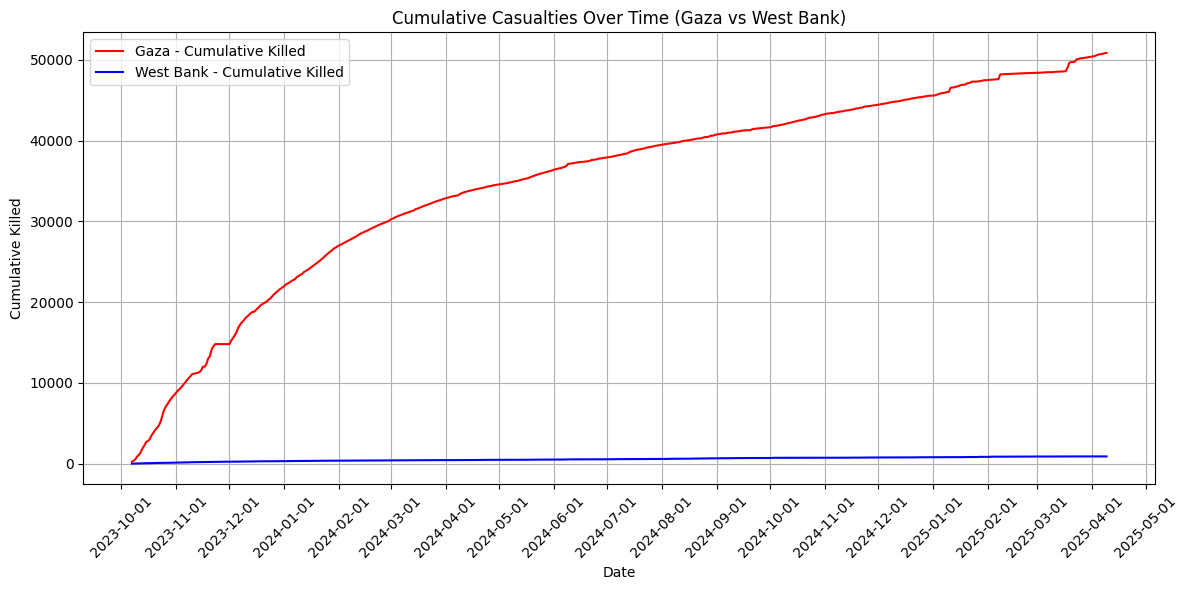

In [95]:


# Convert string dates to datetime objects
gaza_dates = [datetime.strptime(date, '%Y-%m-%d') for date in gaza_clean.column('report_date')]
wb_dates = [datetime.strptime(date, '%Y-%m-%d') for date in wb_complete.column('report_date')]

# Get the cumulative killed data
gaza_killed = gaza_clean.column('killed_cum')
wb_killed = wb_complete.column('killed_cum')

# Plot
plt.clf()
plt.figure(figsize=(12, 6))
plt.plot(gaza_dates, gaza_killed, label='Gaza - Cumulative Killed', color='red')
plt.plot(wb_dates, wb_killed, label='West Bank - Cumulative Killed', color='blue')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Cumulative Killed')
plt.title('Cumulative Casualties Over Time (Gaza vs West Bank)')
plt.legend()
plt.grid(True)

# Adjust x-axis for date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Adjust the frequency of the ticks

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



     


**Key insights**
1. Gaza has an extremely higher cumulative death toll: Gaza's cumulative deaths surpass 50,000, while the West Bank stays near 900. 

2. Gaza experienced sharp and rapid increases: The Gaza curve rises steeply during the first months, indicating heavy and rapid loss of life. This is consistent with the massacres and major offensives in early phases.

3. West Bank deaths increased steadily: The West Bank curve is much flatter and gradual, which suggests lower intensity violence but ongoing and persistent incidents.

4. West Bank curve is smoother with fewer spikes: The West Bank's cumulative deaths increase consistently without major surges. This is because that although deadly, violence there has been more spread out and less catastrophic at any single point (no bombings or urban warfare)

<Figure size 640x480 with 0 Axes>

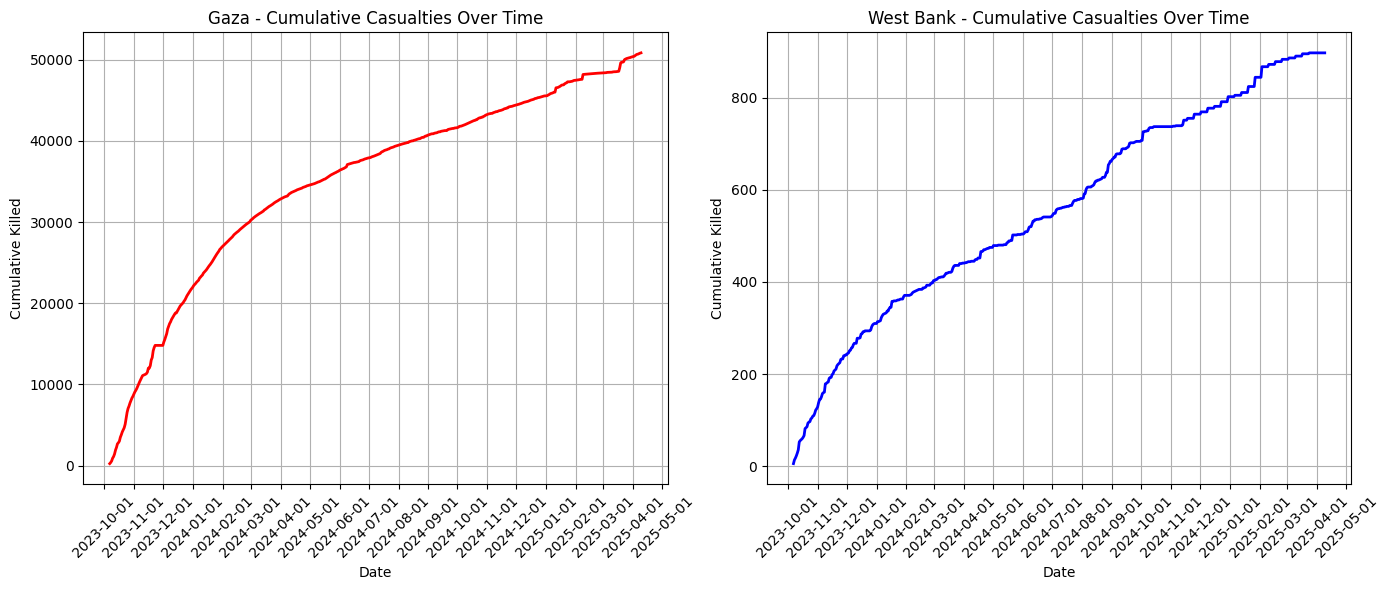

In [97]:
plt.clf()
plt.figure(figsize=(14, 6))

# Gaza plot (Left)
plt.subplot(1, 2, 1)
plt.plot(gaza_dates, gaza_killed, label='Gaza - Cumulative Killed', color='red', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Cumulative Killed')
plt.title('Gaza - Cumulative Casualties Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# West Bank plot (Right)
plt.subplot(1, 2, 2)
plt.plot(wb_dates, wb_killed, label='West Bank - Cumulative Killed', color='blue', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Cumulative Killed')
plt.title('West Bank - Cumulative Casualties Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.tight_layout()
plt.show()

**Key insights**

 Despite the massive difference in absolute scale (Gaza around 50,000, West Bank around 900), the shape of the cumulative curves is very similar. This suggests synchronized escalation cycles by the Israeli occupation. When Gaza offensive phases were intense, violence likely also increased in the West Bank but smaller in scale. This points to a link between the two territories, even if the methods of killings were different (airstrikes vs raids/shootings).


## 2.2 Age Distribution of casualties in Gaza

<Figure size 640x480 with 0 Axes>

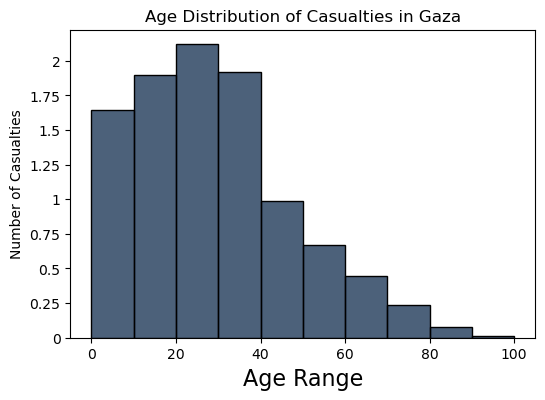

In [ ]:
bins = list(range(0, 101, 10))  # This will create bins like 0-10, 10-20, ..., 90-100

plt.clf()
killed_in_gaza.hist('Age', bins=bins)

plt.xlabel('Age Range')
plt.ylabel('Number of Casualties')
plt.title('Age Distribution of Casualties in Gaza')

plt.show()


**Key insights:**

The age distribution of casualties in Gaza shows some important patterns. Most of the casualties are young adults between 20 and 30 years old. This could be because they are more active and outside during the genocide, as many people at this age are medics, journalists, or volunteers helping others, which could have made them more exposed to attacks even if they were civilians. It might also suggest that younger people are being targeted on purpose, since they are seen as the future of the community. There is also a high number of children under 10 years old among the casualties, which likely reflects how heavy the bombing has been in crowded civilian areas. After the age of 40, the number of casualties starts to drop, possibly because older people move around less or are seen as less of a threat. Very few casualties are seen over the age of 50, which could be because there are fewer elderly people in Gaza or they are more sheltered.

## 2.3 Gender Distribution of Casualties in Gaza

<Figure size 640x480 with 0 Axes>

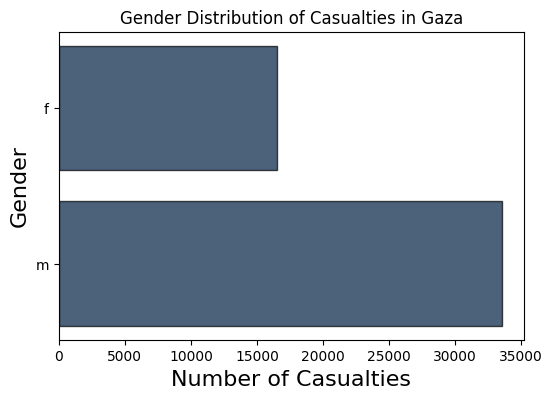

In [3]:
gender_counts = killed_in_gaza.group('Sex')

plt.clf()
gender_counts.barh('Sex', 'count')

plt.xlabel('Number of Casualties')
plt.ylabel('Gender')
plt.title('Gender Distribution of Casualties in Gaza')

plt.show()


**Key insights:**

The gender distribution of casualties in Gaza shows that men make up around twice the number of casualties as women. This likely reflects the fact that men are more often on the front lines or engaging in efforts to support the community. However, the number of female casualties is still significant, showing how the attacks affect everyone, regardless of gender. This reinforces the burtal nature of israel's violience, where no one is safe, regardless of age or sex.

## 2.4 Casualties during Ceasefire

In [28]:
# ------------------------------- Data and Helper Functions -------------------------
#all data from aljazeera
implemented_ceasefires = [
    {'name': 'Nov-Dec 2023 Ceasefire', 'start': '2023-11-24', 'end': '2023-12-01'},
    {'name': 'Jan-Mar 2025 Ceasefire', 'start': '2025-01-19', 'end': '2025-03-17'}
]
proposed_ceasefires = [
    ('2023-12-25', 'Egyptian Proposal'),
    ('2024-02-15', 'Paris Framework'),
    ('2024-03-25', 'UN Resolution'),
    ('2024-05-06', 'Hamas Accepts Proposal'),
    ('2024-05-31', 'Biden Proposal'),
    ('2024-06-10', 'UN Resolution 2735'),
    ('2024-08-15', 'Bridging Proposal')
]
#check if date was during ceasefire or not
def is_ceasefire_period(date):
    for period in implemented_ceasefires:
        start_date = datetime.strptime(period['start'], '%Y-%m-%d')
        end_date = datetime.strptime(period['end'], '%Y-%m-%d')
        if start_date <= date <= end_date:
            return True, period['name']
    return False, "No Ceasefire"

def get_ceasefire_status(date):
    is_ceasefire, _ = is_ceasefire_period(date)
    return is_ceasefire
def get_ceasefire_name(date):
    _, period_name = is_ceasefire_period(date)
    return period_name

In [30]:
# ------------------------------- Create New Table For Plot -------------------------
dates = [datetime.strptime(date, '%Y-%m-%d') for date in daily_casualties_gaza.column('report_date')]
gaza_clean = Table().with_columns(
    'date', dates,
    'killed', daily_casualties_gaza.column('killed'),
    'killed_cum', daily_casualties_gaza.column('killed_cum')
)
daily_rates = []
prev_cum = 0
for i, cum in enumerate(gaza_clean.column('killed_cum')):
    if i == 0 or np.isnan(cum) or np.isnan(prev_cum):
        rate = gaza_clean.column('killed')[i]
    else:
        rate = cum - prev_cum
    daily_rates.append(rate)
    if not np.isnan(cum):
        prev_cum = cum
gaza_clean = gaza_clean.with_column('daily_rate', daily_rates)
#7-day rolling average
rolling_avg = []
window_size = 7
for i in range(len(daily_rates)):
    start = max(0, i - window_size // 2)
    end = min(len(daily_rates), i + window_size // 2 + 1)
    window = [r for r in daily_rates[start:end] if not np.isnan(r)]
    if window:
        rolling_avg.append(sum(window) / len(window))
    else:
        rolling_avg.append(np.nan)
gaza_clean = gaza_clean.with_column('rolling_avg_rate', rolling_avg)

#add ceasefire columns
gaza_clean = gaza_clean.with_columns(
    'in_ceasefire', gaza_clean.apply(get_ceasefire_status, 'date'),
    'ceasefire_period', gaza_clean.apply(get_ceasefire_name, 'date')
)

ceasefire_data = gaza_clean.where('in_ceasefire', True)
non_ceasefire_data = gaza_clean.where('in_ceasefire', False)
avg_daily_ceasefire = np.mean([r for r in ceasefire_data.column('rolling_avg_rate') if not np.isnan(r)])
avg_daily_no_ceasefire = np.mean([r for r in non_ceasefire_data.column('rolling_avg_rate') if not np.isnan(r)])

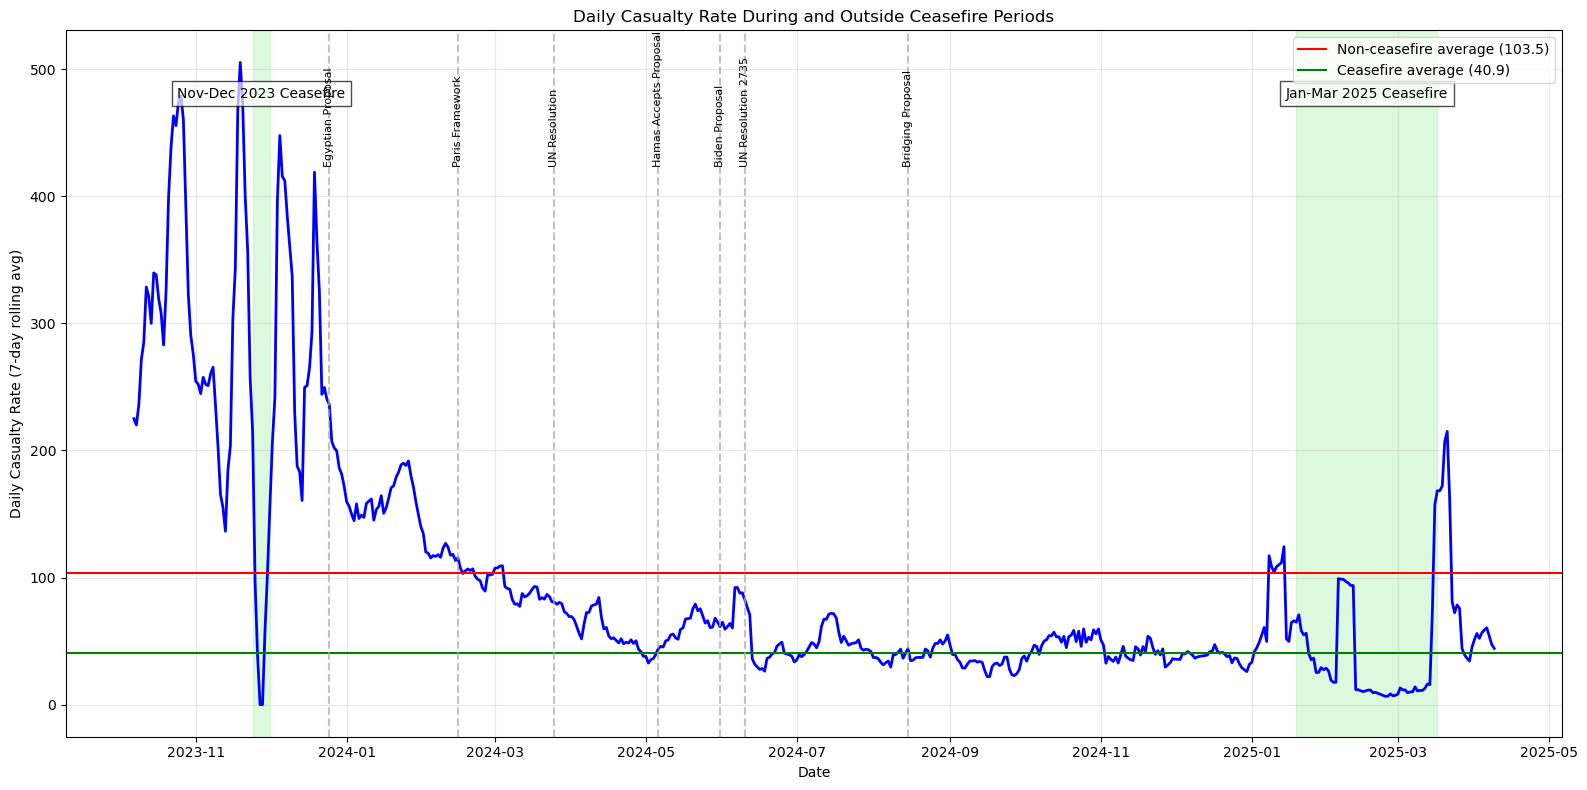

In [32]:
# -------------------------------  Plotting -------------------------
plt.clf
plt.figure(figsize=(16, 8))
plt.plot(gaza_clean.column('date'), gaza_clean.column('rolling_avg_rate'), 'b-', linewidth=2)
plt.ylabel('Daily Casualty Rate (7-day rolling avg)')
plt.xlabel('Date')
plt.title('Daily Casualty Rate During and Outside Ceasefire Periods')
plt.grid(True, alpha=0.3)
plt.axhline(avg_daily_no_ceasefire, color='red', linestyle='-',
           label=f'Non-ceasefire average ({avg_daily_no_ceasefire:.1f})')
plt.axhline(avg_daily_ceasefire, color='green', linestyle='-',
           label=f'Ceasefire average ({avg_daily_ceasefire:.1f})')

#highlight ceasefire periods
for cf in implemented_ceasefires:
    start = datetime.strptime(cf['start'], '%Y-%m-%d')
    end = datetime.strptime(cf['end'], '%Y-%m-%d')
    plt.axvspan(start, end, color='lightgreen', alpha=0.3)
    mid_date = start + (end - start) / 2
    plt.text(mid_date, plt.ylim()[1] * 0.9, cf['name'],
             ha='center', fontsize=10,
             bbox=dict(facecolor='white', alpha=0.7))

#proposed ceasefires
for date_str, name in proposed_ceasefires:
    proposal_date = datetime.strptime(date_str, '%Y-%m-%d')
    plt.axvline(proposal_date, color='darkgray', linestyle='--', alpha=0.7)
    plt.annotate(name, xy=(proposal_date, plt.ylim()[1] * 0.8),
               xytext=(0, 0), textcoords='offset points',
               rotation=90, ha='center', fontsize=8)

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Before analyzing worth noting that this is a rolling 7 day average, which means that sudden changes in casualty rates are smoothed out. This is because it was hard to analyze the actual daily rate in the graph due to it being volatile


**Significant Patterns**

- Sadly, throughout the entire war, there seems to be one small period where the casualty rate reaches zero, suggesting continuous loss of life throughout the war regardless of ceasefire status.

- The highest casualty rates occurred in the early months of the war with some days reaching 400-500 casualties.

- After the first ceasefire, there's a period of consistently high casualties with peaks of above 200 per day, indicating intense military operations resumed immediately after the ceasefire ended.

- A similar trend can be noticed with the second ceasefire period

- just before both ceasefires, there's a significant spike in casualties, potentially suggesting an intensification of operations right before ceasefire implementation.

- adding to the few points above, it seems there are  high-intensity periods immediately before and after ceasefires that might be strategically timed in a way that offsets the reduction during the ceasefire itself.

## 2.5 Cumulative Deaths of Medical and Press Workers in Gaza Over Time

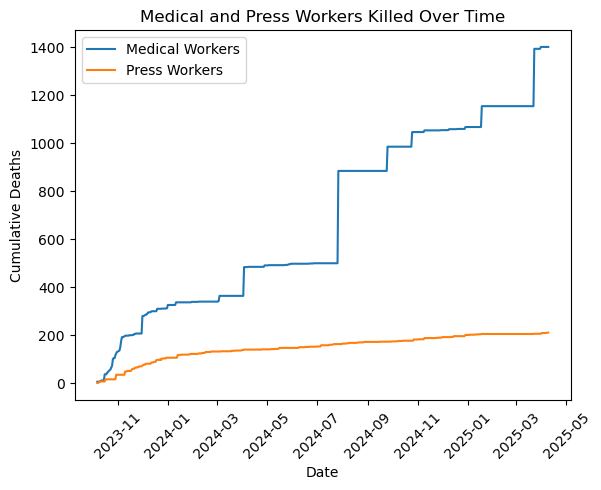

In [52]:
# Convert report_date to datetime format 
gaza_dates = [datetime.strptime(date, '%Y-%m-%d') for date in gaza_clean.column('report_date')]

# Select columns
workers = gaza_clean.select('report_date', 'ext_med_killed_cum', 'ext_press_killed_cum')

# Plot the lines
plt.plot(gaza_dates, workers.column('ext_med_killed_cum'), label='Medical Workers')
plt.plot(gaza_dates, workers.column('ext_press_killed_cum'), label='Press Workers')

plt.xlabel('Date')
plt.ylabel('Cumulative Deaths')
plt.title('Medical and Press Workers Killed Over Time')
plt.legend()

plt.xticks(rotation=45)

plt.show()

**Significant Patterns**
- Medical workers have faced significantly higher fatality rates compared to press workers throughout the timeline of the war.
- Medical worker deaths show sharp, stepwise increases, indicating mass-casualty events or targeted strikes.
- Press worker deaths rise gradually, suggesting a more consistent but lower-risk exposure over time.
- The gap between medical and press worker deaths widens over time, showing increased risk for medical workers.

## 2.6 Multigenerational genocide in most affected families

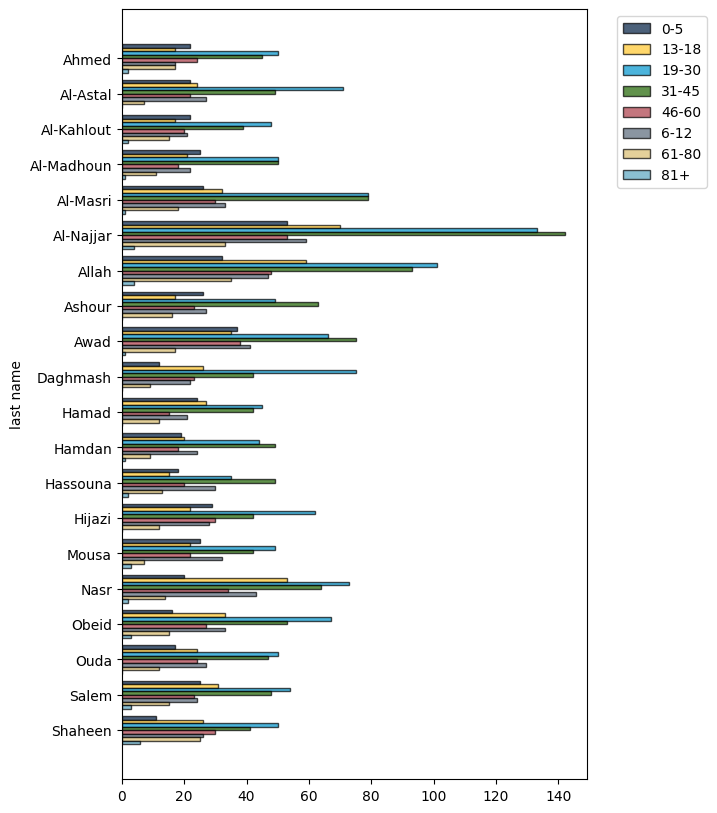

In [ ]:
killed_in_gaza.column('Name').item(0).split(' ')[-1]

def get_last_name(name):
    return name.split(' ')[-1]

lastnames = killed_in_gaza.apply(get_last_name,'Name')

kig_with_lastnames = killed_in_gaza.with_column('last name', lastnames).move_to_start('last name')

top_20_lastnames = Table().with_columns('last name', lastnames).group([0]).sort('count', descending=True).take(np.arange(20)).column('last name')

deaths_in_top_20_families = kig_with_lastnames.where('last name',are.contained_in(top_20_lastnames))

def age_bins(age):
    if age <= 5:
        return "0-5"
    elif age <= 12:
        return "6-12"
    elif age <= 18:
        return "13-18"
    elif age <= 30:
        return "19-30"
    elif age <= 45:
        return "31-45"
    elif age <= 60:
        return "46-60"
    elif age <= 80:
        return "61-80"
    else:
        return "81+"


deaths_in_top_20_families = deaths_in_top_20_families.with_column('age group', deaths_in_top_20_families.apply(age_bins,'Age'))
deaths_in_top_20_families
pivoted = deaths_in_top_20_families.pivot('age group', 'last name')
pivoted.barh('last name')

**Key Insights**

1. Multi-generational deaths are common: Almost every family has deaths across children, adults, and elders. This suggests that entire households, not individuals, were killed together. No family shows deaths limited to just adults or just children. This reinforces the pattern of entire family units being killed.

2. Some families suffered extreme losses: Families such as Al-Najjar, Allah, Al-Astal, and Al-Masri show much larger death counts. Al-Najjar, in particular, stands out as being disproportionately affected.

3. Children represent a large share of deaths: The youngest age groups (0-5, 6-12, 13-18) appear in every family.This indicates a high number of child victims across families.

4. Adults are heavily affected, especially young adults: The 19-30 and 31-45 age groups are typically the largest segments. This is expected in a young population but also suggests adults were heavily targeted or affected.

5. Elderly deaths are lower but consistently present: Older age groups (61-80 and 81+) appear in most families, though in smaller numbers. This suggests that many households, including elders, were destroyed. This is a method of cultural genocide as generational knowledge and teachings were lost.



## 2.7 Settler Violence and Injury Rates in the West Bank

In [ ]:

cum_attacks = daily_casualties_westbank.column("settler_attacks_cum")

daily_attacks = [cum_attacks[0]]  # First day attacks is the cumulative on first day

for i in range(1, len(cum_attacks)):
    daily =cum_attacks[i] - cum_attacks[i - 1]
    daily_attacks.append(daily)

# Add daily attacks as a new column
daily_casualties_westbank = daily_casualties_westbank.with_column("settler_attacks_daily", daily_attacks).where('settler_attacks_daily', are.above_or_equal_to(0))


In [123]:
pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/294.9 kB 1.4 MB/s eta 0:00:01
   ---- ----------------------------------- 30.7/294.9 kB 1.4 MB/s eta 0:00:01
   ---------- ---------------------------- 81.9/294.9 kB 657.6 kB/s eta 0:00:01
   ------------ -------------------------- 92.2/294.9 kB 585.1 kB/s eta 0:00:01
   ------------------------- ------------ 194.6/294.9 kB 841.6 kB/s eta 0:00:01
   -------------------------- ----------- 204.8/294.9 kB 831.5 kB/s eta 0:00:01
   ------------------------------------ - 286.7/294.9 kB 930.9 kB/s eta 0:00:01
   -------------------------------------- 294.9/294.9 kB 912.4 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


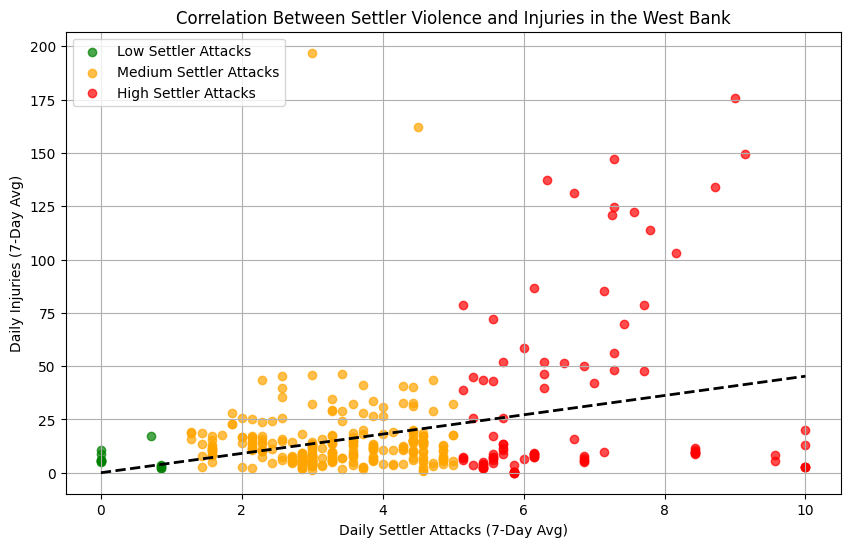

In [135]:

injuries = daily_casualties_westbank.column('verified.injured')
attacks = daily_casualties_westbank.column('settler_attacks_daily')


# Smooth both with 7-day rolling average
def rolling_avg(values, window=7):
    result = []
    for i in range(len(values)):
        window_vals = values[max(0, i-window+1):i+1]
        result.append(sum(window_vals) / len(window_vals))
    return result

injuries_smoothed = rolling_avg(injuries)
attacks_smoothed = rolling_avg(attacks)

# Categorize attack levels
def categorize(attacks):
    if attacks <= 1:
        return "Low"
    elif attacks <= 5:
        return "Medium"
    else:
        return "High"

attack_categories = [categorize(a) for a in attacks_smoothed]

# Create datascience Table
scatter_table = Table().with_columns(
    "Settler Attacks (7-Day Avg)", attacks_smoothed,
    "Injuries (7-Day Avg)", injuries_smoothed,
    "Attack Category", attack_categories
)

import seaborn as sns

plt.figure(figsize=(10, 6))

# First plot scatter points by category
colors = {"Low": "green", "Medium": "orange", "High": "red"}

for category in colors:
    # Get points for this category
    mask = [c == category for c in attack_categories]
    x_vals = np.array(attacks_smoothed)[mask]
    y_vals = np.array(injuries_smoothed)[mask]
    
    # Scatter plot
    plt.scatter(x_vals, y_vals, color=colors[category], alpha=0.7, label=f"{category} Settler Attacks")

# Then plot trendline ONLY (disable scatter)
sns.regplot(x=attacks_smoothed, y=injuries_smoothed,
            scatter=False,   # No scatter
            line_kws={'color': 'black', 'linewidth': 2, 'linestyle': '--'}, ci=None)

# Labels and title
plt.xlabel("Daily Settler Attacks (7-Day Avg)")
plt.ylabel("Daily Injuries (7-Day Avg)")
plt.title("Correlation Between Settler Violence and Injuries in the West Bank")
plt.legend()
plt.grid(True)
plt.show()



**Key Insights**

1. Injuries rise with settler attacks: There is a clear positive trend that as settler attacks increase, daily injuries also increase. However, the slope is moderate which indicates that while attacks drive injuries, other factors contribute too (IDF raids, shootings, etc).

2. High settler attack days result in disproportionately high injuries: The red points (high attack days) show much greater spread and many extreme values. On high attack days, the rate often exceeds 50 injuries and sometimes 100+, indicating clustered violent events during escalations.

3. Medium attack days show significant and frequent injuries: Orange points are heavily clustered between 10 and 50 injuries. This suggests that even at moderate levels of settler attacks, violence is sufficient to cause frequent injuries. There are a few days with a medium number of attacks but very high injury rates, which indiicates that although the number of attacks was not very high, one or more of those attacks was a severely dangerous crimes that inflicted high levels of pain and suffering, (public shootings, violent mobs, etc.).

4. Low settler attack days rarely produce major injuries: Green points are tightly clustered at low injury counts (mostly below 20). This shows that low attack days are much less deadly, though still not peaceful.

5. Violence becomes more unpredictable at higher attack level: Basically, injury outcomes are more volatile during high attack days, ranging from moderate to extreme injury spikes. This reflects the chaotic and unpredictable nature of settler attacks.



In [57]:
# settler attacks vs casualities over time in westband

In [ ]:
# join by report_date, number of building vs num killed in gaza (scatter)

## 3. Hypothesis Testing

## 3.1 Demographic Disparity Hypothesis: Are Children Under 15 Overrepresented Among Fatalities in Gaza?

This hypothesis suggests that children may represent a disproportionately high share of total fatalities in Gaza. Looking at the cumulative casualty data, children appear to make up a large portion of the reported deaths. This raises the question: Is this proportion statistically higher than we would expect based on Gaza’s population structure? A formal hypothesis test is needed to determine whether this difference is statistically significant or could simply be occurring by random chance.

We will use 40.3% as the expected proportion of children under 15 in Gaza, based on 2025 demographic estimates from the Palestinian Central Bureau of Statistics (PCBS), published on the eve of Palestinian Child Day.

Source: https://pcbs.gov.ps/post.aspx?lang=en&ItemID=5965#

### Hypotheses

- **Null Hypothesis (H₀)**: The proportion of children (under 15) among those killed in Gaza is not significantly different from the proportion of children in Gaza’s general population (40.3%). Any observed difference is due to random chance.
- **Alternative Hypothesis (H₁)**: The proportion of children (under 15) among those killed is greater than their proportion in the general population.

### Test Statistic

**Test Statistic:** The observed proportion of children among all fatalities with known ages.

- Observed Proportion of Children = Number of Children Killed / Total Number of All Ages Killed

This observed proportion is compared against a simulated null distribution, where samples of the same size are drawn using the population-based probability (40.3% children).

### Implementation

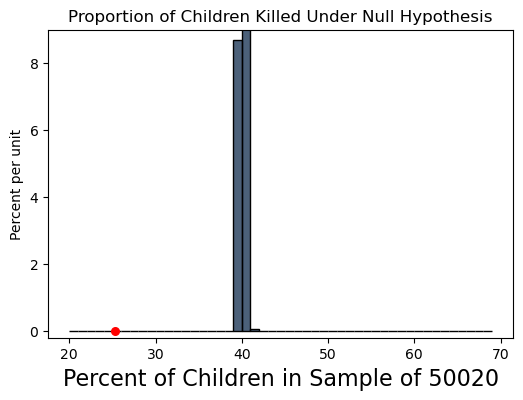

P-value: 1.0
With a p-value of 1.0000, we fail to reject the null hypothesis.
There is not sufficient evidence to conclude that children under 15 are overrepresented among the deceased relative to their population share.


In [173]:
# Expected population proportions (children vs. others)
population_proportions = make_array(0.403, 1 - 0.403)

# Observed proportion of children among those killed
total_killed = killed_in_gaza.num_rows
num_children_killed = killed_in_gaza.where('Age', are.below(15)).num_rows

observed_child_prop = num_children_killed / total_killed

# Function to simulate one sample under the null hypothesis
def simulate_child_proportion():
    return sample_proportions(total_killed, population_proportions).item(0)

# Simulation 10,000 times to generate null distribution
simulated_child_percents = make_array()
number_iteration = 10000

for i in np.arange(number_iteration):
    new_sim = simulate_child_proportion() * 100
    simulated_child_percents = np.append(simulated_child_percents, new_sim)

# Plot of null distribution with observed value overlaid
Table().with_column(
    'Simulated % of Children (Under 15)', simulated_child_percents
).hist(bins=np.arange(20, 70, 1))

# Overlay of observed % of children killed as a red dot
plt.ylim(-0.002, 0.09)
plt.scatter(observed_child_prop * 100, 0, color='red', s=30)
plt.title('Proportion of Children Killed Under Null Hypothesis')
plt.xlabel('Percent of Children in Sample of ' + str(total_killed))
plt.show()

# Conclusion and p-value
p_value = np.count_nonzero(simulated_child_percents >= observed_child_prop * 100) / number_iteration
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print(f"P-value is {p_value:.4f}, we reject the null hypothesis.")
    print('''There is statistically significant evidence that children under 15 are overrepresented among those killed in Gaza compared to their population share.''')
else:
    print(f"With a p-value of {p_value:.4f}, we fail to reject the null hypothesis.")
    print('''There is not sufficient evidence to conclude that children under 15 are overrepresented among the deceased relative to their population share.''')

### Conclusion

Based on the simulation test, we find no statistically significant evidence that children under the age of 15 are overrepresented among the fatalities in Gaza. With a p-value of 1.0, we fail to reject the null hypothesis, suggesting that the impact on children, while severe in absolute terms, is not disproportionate relative to their share of the general population.

## 3.2 Tactical Timing Hypothesis: Spike in Casualties Before and After Ceasefires

This hypothesis suggests that there might be significant increase in daily casualties before and after ceasefires compared to other war periods. Looking at the "Casualties during Ceasefire" graph, there are spikes in casualties (using the 7-day average) just before ceasefires started and right after they ended. This raised questions about whether military operations might be strategically intensifying around these ceasefire periods. A formal hypothesis test is needed to determine if these differences are statistically significant or if they could simply be occurring by random chance.

### Hypotheses

- **Null Hypothesis (H₀)**
The average daily casualty rate during the periods immediately before and after ceasefire periods is not significantly different from the average daily casualty rate during other non-ceasefire periods. Any observed differences are due to random chance.


- **Alternative Hypothesis (H₁)**
The average daily casualty rate during the periods immediately before and after ceasefire periods is significantly higher than the average daily casualty rate during other non-ceasefire periods.

### Test Statistic

**Test statistic**: the difference between:

- The mean daily casualty rate (7-day rolling average) during the 14-day periods immediately before and after ceasefire implementations
- The mean daily casualty rate (7-day rolling average) during all other non-ceasefire periods

This test statistic measures whether there is an increase in casualty rates surrounding ceasefire periods. The alternative hypothesis states that casualty rates are higher in pre/post-ceasefire periods, not just different, therefore we use the difference rather than the absolute difference.

### Implementation

This analysis is fundamentally a comparison of two samples:

- Sample 1: Daily casualty rates from the 14-day periods immediately before and after ceasefires

- Sample 2: Daily casualty rates from all other non-ceasefire periods

The question is whether these two samples come from the same underlying distribution (as the null hypothesis suggests) or from different distributions with different higher means (as the alternative hypothesis suggests).

In [37]:
#check if date falls within 14 days before or after a ceasefire period
def is_pre_post_ceasefire(date):
    window_days = 14  #2 weeks
    for period in implemented_ceasefires:
        start = datetime.strptime(period['start'], '%Y-%m-%d')
        end = datetime.strptime(period['end'], '%Y-%m-%d')
        #check if before ceasefire
        pre_start = start - timedelta(days=window_days)
        if pre_start <= date < start:
            return True, f"Pre-{period['name']}"
        #check if after
        post_end = end + timedelta(days=window_days)
        if end < date <= post_end:
            return True, f"Post-{period['name']}"

    return False, "Regular non-ceasefire"
gaza_clean = gaza_clean.with_columns(
    'in_pre_post_ceasefire', gaza_clean.apply(lambda date: is_pre_post_ceasefire(date)[0], 'date'),
    'pre_post_period', gaza_clean.apply(lambda date: is_pre_post_ceasefire(date)[1], 'date')
)

Average daily casualty rate during pre/post ceasefire period: 196.05
Average daily casualty rate during war, non-ceasefire periods: 91.45
Observed difference (observed test statistic): 104.60
P-value from permutation test: 0.0000


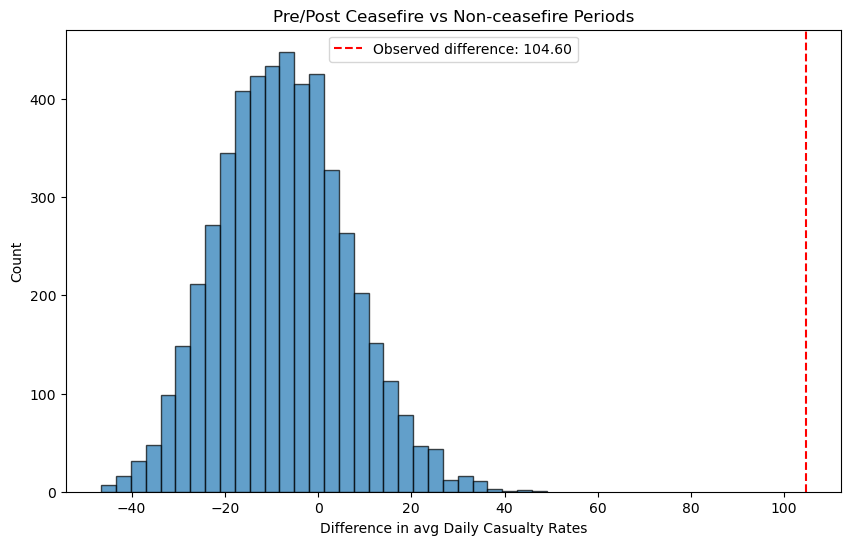

p-value is 0.0000, we reject the null hypothesis.
statistically significant evidence that casualty rates are higher in the periods
immediately before and after ceasefires compared to other non-ceasefire periods.


In [43]:
#calc average daily casualty rates
pre_post_ceasefire_data = gaza_clean.where('in_pre_post_ceasefire', True)
regular_nonceasefire_data = gaza_clean.where('in_pre_post_ceasefire', False).where('in_ceasefire', False)
avg_pre_post = np.mean([r for r in pre_post_ceasefire_data.column('rolling_avg_rate') if not np.isnan(r)])
avg_regular = np.mean([r for r in regular_nonceasefire_data.column('rolling_avg_rate') if not np.isnan(r)])

#observed test statistic
observed_difference = avg_pre_post - avg_regular

print(f"Average daily casualty rate during pre/post ceasefire period: {avg_pre_post:.2f}")
print(f"Average daily casualty rate during war, non-ceasefire periods: {avg_regular:.2f}")
print(f"Observed difference (observed test statistic): {observed_difference:.2f}")

# ----------------------------- Permutation Testing -----------------------------------
def compute_test_statistic(table, labels, values):
    group1 = table.where(labels, True)
    group2 = table.where(labels, False).where('in_ceasefire', False)
    mean1 = np.mean([r for r in group1.column(values) if not np.isnan(r)])
    mean2 = np.mean([r for r in group2.column(values) if not np.isnan(r)])
    return mean1 - mean2

test_table = Table().with_columns(
    'rolling_avg_rate', gaza_clean.column('rolling_avg_rate'),
    'in_pre_post_ceasefire', gaza_clean.column('in_pre_post_ceasefire'),
    'in_ceasefire', gaza_clean.column('in_ceasefire')
)
#repetition
num_repetitions = 5000
differences = make_array()
for i in np.arange(num_repetitions):
    #shuffling
    shuffled_labels = test_table.sample(test_table.num_rows, with_replacement=False).column('in_pre_post_ceasefire')
    shuffled_table = test_table.with_column('in_pre_post_ceasefire', shuffled_labels)
    #compute shuffled test statistic
    new_difference = compute_test_statistic(shuffled_table, 'in_pre_post_ceasefire', 'rolling_avg_rate')
    differences = np.append(differences, new_difference)

# ----------------------------- Conclusion & p-value -----------------------------------
p_value = np.count_nonzero(differences >= observed_difference) / num_repetitions
print(f"P-value from permutation test: {p_value:.4f}")

plt.figure(figsize=(10, 6))
plt.hist(differences, bins=30, alpha=0.7)
plt.axvline(observed_difference, color='red', linestyle='--',
            label=f'Observed difference: {observed_difference:.2f}')
plt.xlabel('Difference in avg Daily Casualty Rates')
plt.ylabel('Count')
plt.title('Pre/Post Ceasefire vs Non-ceasefire Periods')
plt.legend()
plt.show()
alpha = 0.05
if p_value < alpha:
    print(f"p-value is {p_value:.4f}, we reject the null hypothesis.")
    print("statistically significant evidence that casualty rates are higher in the periods")
    print("immediately before and after ceasefires compared to other non-ceasefire periods.")
else:
    print(f"With a p-value of {p_value:.4f}, we fail to reject the null hypothesis.")
    print("not sufficient evidence that casualty rates are higher in the periods")
    print("immediately before and after ceasefires compared to other non-ceasefire periods.")

### Conclusion

Our analysis of casualty data shows evidence for the Tactical Timing Hypothesis. Daily casualty rates during the periods immediately before and after ceasefires (196.05) are much higher than during regular non-ceasefire periods (91.45)
Moreover with p-value of 0.0000, we reject the null hypothesis. This indicates that the pattern of increased violence surrounding ceasefire periods is not due to random chance, suggesting that military operations may be strategically increased around these negotiated pauses in the war.

## 3.3 Targeting of Militants vs. Civilians: Does Israel's Violence Specifically Target Militants or Is It Indiscriminate?

This hypothesis questions whether Israel’s claim of specifically targeting militants aligns with the demographic breakdown of casualties. Given the significant number of civilian casualties, especially among women, children, and the elderly, it raises the possibility that Israel's actions might be indiscriminate rather than specifically targeting militants. A formal hypothesis test is needed to determine if the demographics of casualties reflect a targeting of militants or if Israel’s actions disproportionately affect civilians.

### Hypotheses

- **Null Hypothesis (H₀)**
Israel targets individuals based on military affiliation (militants, fighters, etc.). The age and gender distribution of casualties reflects that of the population, with the higher proportion of casualties being military-aged men, and civilian casualties being collateral damage.


- **Alternative Hypothesis (H₁)**
Israel’s violence is indiscriminate, targeting individuals regardless of military affiliation. The casualty demographics reflect that Israel’s strikes affect civilians, with no clear targeting of militants, as suggested by the proportion of casualties in various demographic groups (children, women, the elderly).

### Test Statistic

**Test statistic**: The Total Variation Distance (TVD) between:

- The demographic distribution of actual casualties in Gaza by age-gender categories
- The expected demographic distribution if targeting was focused on militants

The TVD measures how much the casualty demographics differ from the expected military-affiliated population demographics. A significant difference would suggest indiscriminate violence, where civilians are disproportionately affected.

### Implementation

- Categorize each casualty into demographic groups based on age and gender (military-aged males and other).
- Define an expected disribution of militant-focused operations, with 50% of casualties being military-aged males
- Conduct a simulation test with 10,000 simulations to determine if the observed demographic distribution could reasonably occur under the null hypothesis:

In [126]:
def categorize_casualty(sex, age):
    """
    Categorize casualties based on sex and age.
    Military-aged males are typically defined as males between 18-49
    """
    if sex == 'm' and 18 <= age <= 49:
        return "Military-aged male"
    else:
        return "Other"

categorized_casualties = killed_in_gaza.with_column(
    'Category', 
    killed_in_gaza.apply(categorize_casualty, 'Sex', 'Age')
)

In [ ]:
category_counts = categorized_casualties.group('Category')
total_casualties = sum(category_counts.column('count'))
category_counts = category_counts.with_column(
    'Percentage', 
    category_counts.column('count') / total_casualties * 100
)

expected_percentages = make_array(0.5, 0.5)  # Expected percentages in targeted operations

demographic_table = Table().with_columns(
    'Category', make_array('Military-aged male', 'Other'),
    'Expected %', expected_percentages)  


observed_percentages = make_array()
for category in demographic_table.column('Category'):
    matching_rows = category_counts.where('Category', category)
    if matching_rows.num_rows > 0:
        observed_percentages = np.append(observed_percentages, matching_rows.column('Percentage')[0])
    else:
        observed_percentages = np.append(observed_percentages, 0)

demographic_table = demographic_table.with_column('Observed %', observed_percentages/100)

demographic_table = demographic_table.with_column(
    'Difference', 
    demographic_table.column('Observed %') - demographic_table.column('Expected %')
)

print("Comparision table")
demographic_table.show()




Comparision table


Category,Expected %,Observed %,Difference
Military-aged male,0.5,0.40114,-0.0988605
Other,0.5,0.59886,0.0988605


In [150]:
def tvd(dist1, dist2):
    """Calculate Total Variation Distance between two distributions"""
    return sum(abs(dist1 - dist2)) / 2


In [151]:
observed_tvd = tvd(demographic_table.column('Observed %'), demographic_table.column('Expected %'))
observed_tvd

0.098860455817672888

In [152]:
tvd(sample_proportions(50021, (expected_percentages)), expected_percentages)

0.0023290218108394656

In [153]:
def simulated_tvd():
    return tvd(sample_proportions(50021, (expected_percentages)), expected_percentages)

In [154]:
tvds = make_array()

num_simulations = 10000
for i in np.arange(num_simulations):
    new_tvd = simulated_tvd()
    tvds = np.append(tvds, new_tvd)

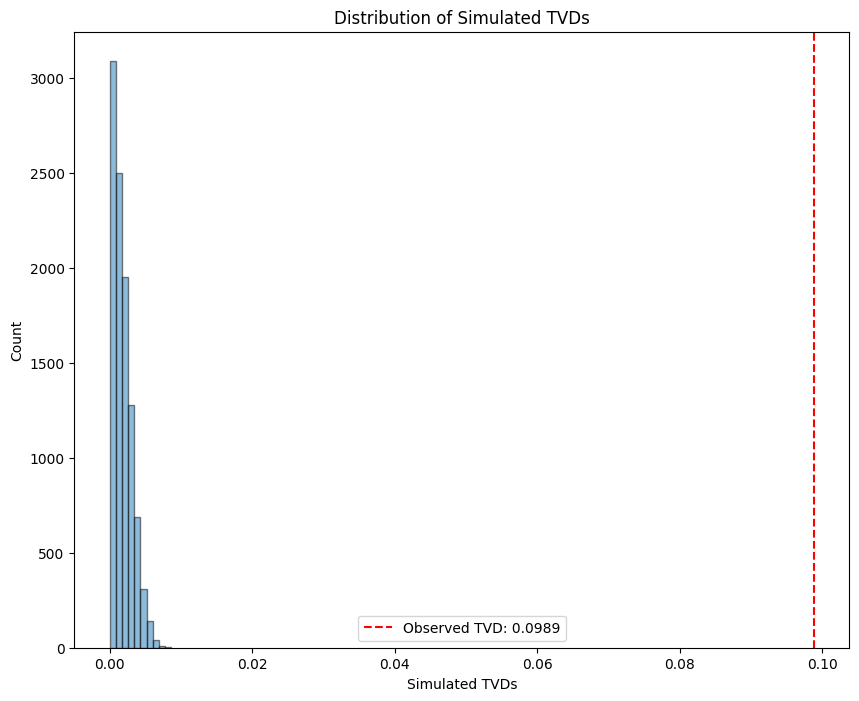

In [160]:
plt.figure(figsize=(10, 8))
plt.hist(tvds, alpha=0.5)
plt.axvline(observed_tvd, color='red', linestyle='--',
            label=f'Observed TVD: {observed_tvd:.4f}')
plt.xlabel('Simulated TVDs')
plt.ylabel('Count')
plt.title('Distribution of Simulated TVDs')
plt.legend()
plt.show()

In [156]:
p_value = sum(tvds >= observed_tvd) / num_simulations
p_value

0.0

### Conclusion

Based on our statistical analysis, we obtained a p-value of 0, which means we strongly reject the null hypothesis. This provides statistical evidence that Israel's violence is not specifically targeting militants as claimed. The demographic distribution of casualties in Gaza shows a pattern that is significantly different from what would be expected if operations were primarily targeting military-aged males. In our model, we assumed that 50% of casualties would be military-aged males. However, if Israel were truly targeting militants, the proportion should be significantly higher than 50%. Despite this generous assumption, the actual data did not even reach this threshold, further asserting that Israel's violence is indiscriminate.